# From Title to Thumbnail: Baseline 1 Stable Diffusion Text-to-Image Model

Hugging Face pre-trained Text-to-Image model finetuned on Youtube Thumbnail Dataset

References:
Pre-trained Model - https://huggingface.co/docs/diffusers/training/text2image

Datasets:
https://www.kaggle.com/datasets/praneshmukhopadhyay/youtubers-saying-things
https://www.kaggle.com/datasets/praneshmukhopadhyay/youtube-thumbnail-dataset/data

I. Prerequisites

In [1]:
!pip install huggingface_hub --upgrade

from huggingface_hub import login

login()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.7/311.7 kB 6.3 MB/s eta 0:00:00


In [2]:
!pip install git+https://github.com/huggingface/diffusers.git
!pip install --upgrade diffusers transformers scipy accelerate datasets huggingface_hub torchvision ftfy Jinja2
!nvidia-smi

from diffusers import StableDiffusionPipeline

# device = 'cuda' if torch.cuda.is_available() else 'cpu'

  Cloning https://github.com/huggingface/diffusers.git to /tmp/pip-req-build-jori7vlp
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers.git /tmp/pip-req-build-jori7vlp
  Resolved https://github.com/huggingface/diffusers.git to commit ff573ae245166d8b958950f68eb65ea766f07f69
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.0 MB/s eta 0:00:00
  Created wheel for diffusers: filename=diffusers-0.24.0.dev0-py3-none-any.whl size=1685557 sha256=15ddf7a2d131c6ae065f9642757de84d2d667255e5898b74f56b545759fc3e2b
  Stored in directory: /tmp/pip-ephem-wheel-cache-3k6gv2p8/wheels/4d/b7/a8/6f9549ceec5daad78675b857ac57d697c387062506520a7b50
Successfully built diffusers
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 49.0 MB/

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

II. Dataset Preparation

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

In [ ]:
# # Used previously to convert Jasmine's train.csv -> metadata.csv
# import pandas as pd

# # Read the CSV file
# df = pd.read_csv('baseline/train.csv')

# # Select and rename columns
# df = df[['Id', 'Title']]
# df.columns = ['file_name', 'text']

# # Modify the file_name column
# df['file_name'] = df['file_name'].astype(str) + '.jpg'

# # Save to new CSV file
# df.to_csv('baseline/metadata.csv', index=False)

In [ ]:
%cd gdrive/MyDrive

from datasets import load_dataset
train_dataset = load_dataset('imagefolder', data_dir='train_baseline')

In [ ]:
# Check if dataset import is formatted correctly

from IPython.display import display
display(train_dataset["train"][0]["image"])

print(train_dataset["train"][0]["text"])

In [ ]:
train_dataset.push_to_hub("lakong/yt-thumbnails-train")

III. Script for Training

IV. Running the model

In [3]:
MODEL_NAME = "CompVis/stable-diffusion-v1-4"
OUTPUT_DIR = "lauren_finetuned_model"
TRAIN_DIR = "lakong/yt-thumbnails-train"

In [4]:
from accelerate.utils import write_basic_config

write_basic_config()

PosixPath('/root/.cache/huggingface/accelerate/default_config.yaml')

In [5]:
import torch
torch.cuda.empty_cache()
!export PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:32

In [37]:
!accelerate launch train_text_to_image.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --dataset_name=$TRAIN_DIR \
  --use_ema \
  --resolution=128 --center_crop --random_flip \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 \
  --gradient_checkpointing \
  --max_train_steps=1201 \
  --learning_rate=1e-05 \
  --max_grad_norm=1 \
  --lr_scheduler="constant" --lr_warmup_steps=0 \
  --checkpointing_steps=100 \
  --output_dir=$OUTPUT_DIR \
  --snr_gamma=5.0 \
  --resume_from_checkpoint="checkpoint-1200" \
  --push_to_hub

The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_cpu_threads_per_process` was set to `8` to improve out-of-box performance when training on CPUs
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
2023-11-17 18:04:37.100811: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
11/17/2023 18:04:38 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cpu

Mixed precision type: no

{'variance_type', 'dynamic_thresholding_ratio', 'timestep_spacing', 'clip_sample_range', 'thresholding', 'prediction_type', 'sample_max_value'} was not found in config. Values will be initialized to default values.
{'force_upcast', 'norm_num_groups'} was not found in config. Values will be initialized to default values.
{'projection_class_embeddings_input_dim', 'dropout', 'transformer_layers_per_block', 'use_l

IV. Inference

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

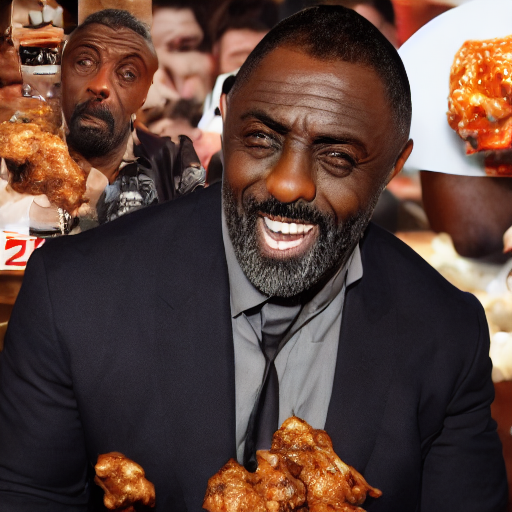

In [57]:
pipe = StableDiffusionPipeline.from_pretrained("lauren_finetuned_model", use_safetensors=True)

inference_prompt = "Idris Elba Wants to Fight While Eating Spicy Wings"
image = pipe(prompt=inference_prompt).images[0]
display(image)

  0%|          | 0/50 [00:00<?, ?it/s]

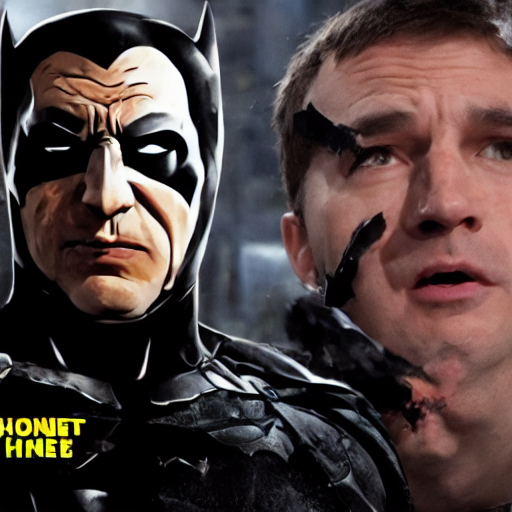

In [41]:
knight_inference_prompt = "Honest Trailers - The Dark Knight Rises (Feat. RedLetterMedia)"
knight_image = pipe(prompt=knight_inference_prompt).images[0]
display(knight_image)

  0%|          | 0/50 [00:00<?, ?it/s]

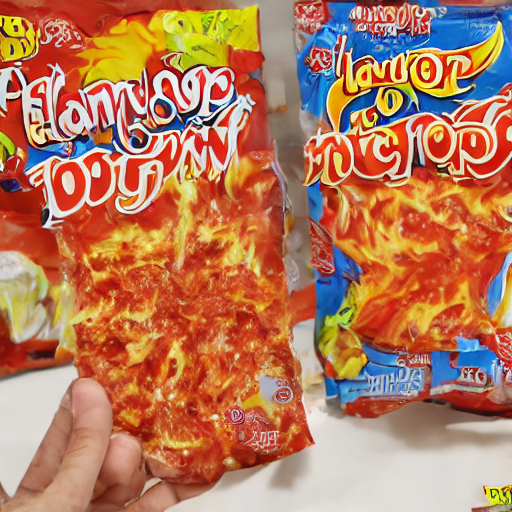

In [43]:
flamin_inference_prompt = "Flamin’ Hot Pop-Tarts Taste Test | SNACK SMASH"
flamin_image = pipe(prompt=flamin_inference_prompt).images[0]
display(flamin_image)

  0%|          | 0/50 [00:00<?, ?it/s]

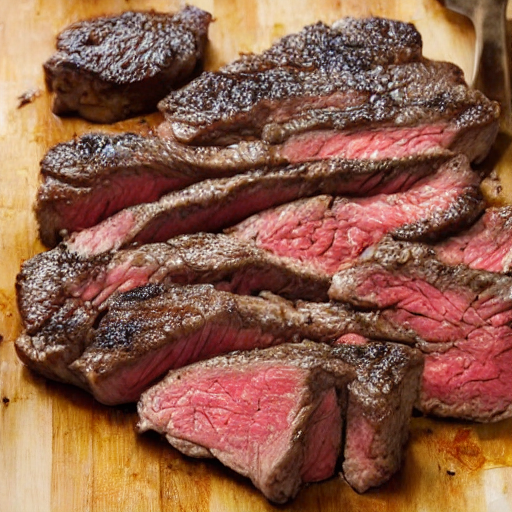

In [42]:
steak_inference_prompt = "Every Way to Make Steak | Bon Appetite"
steak_image = pipe(prompt=steak_inference_prompt).images[0]
display(steak_image)

V. Save Model to HuggingFace for Future Reference

In [ ]:
from huggingface_hub import hf_api
api = HfApi()

api.upload_folder(
    folder_path="lauren_finetuned_model",
    repo_id="lakong/colab_results",
    repo_type="space",
)

In [56]:
pipe.push_to_hub("lauren_finetuned_model")

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

'https://huggingface.co/lakong/lauren_finetuned_model/tree/main/'